In [140]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

import datetime

import json # library to handle JSON files
%matplotlib inline

In [31]:
# import the data set
df = pd.read_csv('/Users/no50free/GitHub/NiceRide/201908-niceride-tripdata.csv')

In [2]:
df.head(3)

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type
0,811,2019-08-01 00:00:44.8830,2019-08-01 00:14:16.2140,191.0,Park Ave & 4th Street S,44.975907,-93.260061,198.0,5th Street NE & 3rd Ave NE,44.991914,-93.255799,262,Subscriber,1991,2,Classic
1,99,2019-08-01 00:00:48.1090,2019-08-01 00:02:27.5170,43.0,Nicollet Mall & 10th Street,44.973839,-93.274544,8.0,YWCA Downtown,44.972217,-93.276435,477,Subscriber,1990,2,Classic
2,1205,2019-08-01 00:02:34.2950,2019-08-01 00:22:39.7020,69.0,N Washington Ave & 9th Ave N,44.989909,-93.279788,199.0,3rd Street NE & Lowry Ave NE,45.013040,-93.264573,24,Customer,1994,1,Classic


In [99]:
# import weather data

df_weather = pd.read_csv('/Users/no50free/GitHub/NiceRide_network_analysis/data/weather_2019.csv')
df_weather.head()

,Unnamed: 0,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation
0,0,2019-04-22,11:53 PM,49,13,40,0.0
1,1,2019-04-22,12:53 AM,49,13,40,0.0
2,2,2019-04-22,1:53 AM,48,14,40,0.0
3,3,2019-04-22,2:53 AM,46,14,41,0.0
4,4,2019-04-22,3:53 AM,46,13,41,0.0


In [ ]:
# Create a datetime column in the weather dataframe
for j in df_weather.index:
    df_weather.loc[j, 'DateTime'] = pd.to_datetime(df_weather.Day[j] +' '+ df_weather.Time[j])

The way that the data is presented on Wunderground puts the 11:53 PM time on the next day. That is, the first entry in the table when you look up history for August 2, say, is 11:53PM August 1. So when I scraped the data, the entries for 11:53 PM have the wrong day attached to them. It should be the previous day. To remedy this, run the following code.

In [134]:
# create a mask of times where the entry is 11:53PM
mask = df_weather[df_weather.Time = '11:53 PM']

# for each index in the mask, update the datetime-stamp to be the previous day.
for index in df_weather.loc[mask].index:
    df_weather.loc[index,'DateTime'] += datetime.timedelta(days=-1)

,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime
0,2019-04-22,11:53 PM,49,13,40,0.0,2019-04-22 23:53:00
53,2019-04-23,11:53 PM,40,7,37,0.0,2019-04-23 23:53:00
77,2019-04-24,11:53 PM,52,7,36,0.0,2019-04-24 23:53:00
100,2019-04-25,11:53 PM,63,6,44,0.0,2019-04-25 23:53:00
124,2019-04-26,11:53 PM,50,14,20,0.0,2019-04-26 23:53:00
...,...,...,...,...,...,...,...
6479,2019-11-25,11:53 PM,38,10,28,0.0,2019-11-25 23:53:00
6514,2019-11-26,11:53 PM,31,17,29,0.1,2019-11-26 23:53:00
6564,2019-11-27,11:53 PM,26,8,17,0.0,2019-11-27 23:53:00
6594,2019-11-28,11:53 PM,28,7,24,0.0,2019-11-28 23:53:00


# Convert time in biking dataframe

In [32]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Add start hour
df['start_hour'] = df['start_time'].dt.hour

# Add day of week
df['startdayofweek'] = df['start_time'].dt.dayofweek
df['enddayofweek'] = df['end_time'].dt.dayofweek

# Convert tripduration to minutes instead of seconds
df.tripduration = df.tripduration/60

# Add weather to bike data

In [178]:
start_date = '2019-07-31'
end_date = '2019-09-02'
mask = (df_weather["DateTime"] > start_date) & (df_weather["DateTime"] < end_date)
df_august=df_weather.loc[mask]
df_august.reset_index(drop=True, inplace=True)
print(df_august.shape)
df_august.head(5)

(954, 7)


,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime
0,2019-07-31,12:53 AM,65,3,54,0.0,2019-07-31 00:53:00
1,2019-07-31,1:53 AM,63,5,55,0.0,2019-07-31 01:53:00
2,2019-07-31,2:53 AM,62,0,54,0.0,2019-07-31 02:53:00
3,2019-07-31,3:53 AM,62,3,53,0.0,2019-07-31 03:53:00
4,2019-07-31,4:53 AM,60,5,55,0.0,2019-07-31 04:53:00


In [174]:
df_august.tail()

,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime
917,2019-08-31,7:53 PM,68,6,55,0.0,2019-08-31 19:53:00
918,2019-08-31,8:53 PM,67,5,55,0.0,2019-08-31 20:53:00
919,2019-08-31,9:53 PM,66,8,55,0.0,2019-08-31 21:53:00
920,2019-08-31,10:53 PM,64,7,54,0.0,2019-08-31 22:53:00
921,2019-09-01,11:53 PM,61,6,55,0.0,2019-08-31 23:53:00


In [150]:
df_august.reset_index(inplace=True)
start = df_august['DateTime'][25]
end = df_august['DateTime'][26]
print(start)
print(end)

2019-08-01 01:53:00
2019-08-01 02:53:00


In [153]:
wmask = (df.start_time >start) & (df.start_time <=end)
sum(wmask)

18

In [158]:
df_august.iloc[25].to_dict()['Temperature']

67

In [161]:
df_august.drop(columns=['level_0', 'index'],inplace=True)
df_august.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Day,Time,Temperature,Wind Speed,Dew Point,Precipitation,DateTime
0,2019-07-31,12:53 AM,65,3,54,0.0,2019-07-31 00:53:00
1,2019-07-31,1:53 AM,63,5,55,0.0,2019-07-31 01:53:00
2,2019-07-31,2:53 AM,62,0,54,0.0,2019-07-31 02:53:00
3,2019-07-31,3:53 AM,62,3,53,0.0,2019-07-31 03:53:00
4,2019-07-31,4:53 AM,60,5,55,0.0,2019-07-31 04:53:00


In [180]:
for j in range(len(df_august)-1):
    start = df_august.DateTime[j]
    end = df_august.DateTime[j+1]
    temp_mask = (df.start_time > start) & (df.start_time <=end)
    temp_dict = df_august.iloc[j].to_dict()
    df.loc[temp_mask,"temperature"] = temp_dict['Temperature']
    df.loc[temp_mask,"wind_speed"] = temp_dict['Wind Speed']
    df.loc[temp_mask,"dew_point"] = temp_dict['Dew Point']
    df.loc[temp_mask,"precipitation"] = temp_dict['Precipitation'] 

In [181]:
df.tail(15)

,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,long_trip,start station x,start station y,end station x,end station y,station_distance,temperature,wind_speed,dew_point,precipitation
72619,2.666667,2019-08-31 23:36:59.337,2019-08-31 23:39:39.676,209.0,Willey Hall,44.972404,-93.242891,190.0,Weisman Art Museum,44.973428,...,False,859720.802589,319436.690910,860159.248081,319554.604418,556.359000,64.0,7.0,54.0,0.0
72621,18.850000,2019-08-31 23:37:12.848,2019-08-31 23:56:04.454,NaN,NaN,44.960000,-93.290000,NaN,NaN,44.980000,...,False,856016.910843,318024.987861,857574.962729,320261.322732,3794.386757,64.0,7.0,54.0,0.0
72624,39.216667,2019-08-31 23:39:07.033,2019-09-01 00:18:20.309,191.0,Park Ave & 4th Street S,44.975907,-93.260061,35.0,Oak Street Ramp,44.971931,...,False,858362.910407,319813.589089,860976.607401,319395.903812,3031.382271,64.0,7.0,54.0,0.0
72625,39.400000,2019-08-31 23:39:08.253,2019-09-01 00:18:32.672,191.0,Park Ave & 4th Street S,44.975907,-93.260061,35.0,Oak Street Ramp,44.971931,...,False,858362.910407,319813.589089,860976.607401,319395.903812,3031.382271,64.0,7.0,54.0,0.0
72628,5.983333,2019-08-31 23:41:24.622,2019-08-31 23:47:23.931,47.0,Lake Street & Humboldt,44.948650,-93.300770,47.0,Lake Street & Humboldt,44.948650,...,False,855177.999282,316756.432913,855177.999282,316756.432913,0.000000,64.0,7.0,54.0,0.0
72631,35.233333,2019-08-31 23:41:36.732,2019-09-01 00:16:51.224,94.0,Portland Ave & Washington Ave,44.978210,-93.260230,94.0,Portland Ave & Washington Ave,44.978210,...,False,858347.266953,320069.321764,858347.266953,320069.321764,0.000000,64.0,7.0,54.0,0.0
72632,14.266667,2019-08-31 23:44:59.372,2019-08-31 23:59:16.042,NaN,NaN,44.950000,-93.300000,NaN,NaN,44.970000,...,False,855237.475768,316906.966910,856796.073167,319143.106473,3794.736963,64.0,7.0,54.0,0.0
72633,5.383333,2019-08-31 23:45:27.592,2019-08-31 23:50:50.675,184.0,S 5th Street & Nicollet Mall,44.978665,-93.270503,102.0,West 15th Street & Willow,44.968237,...,False,857536.593742,320112.640257,856640.741146,318945.817062,2062.675792,64.0,7.0,54.0,0.0
72634,5.450000,2019-08-31 23:46:01.012,2019-08-31 23:51:28.142,149.0,N 4th Ave & W River Parkway,44.988461,-93.269087,94.0,Portland Ave & Washington Ave,44.978210,...,False,857638.561759,321202.172022,858347.266953,320069.321764,1841.555451,64.0,7.0,54.0,0.0
72635,29.633333,2019-08-31 23:46:28.453,2019-09-01 00:16:07.320,804.0,NE Water Street & NE 13th Ave,44.999819,-93.273200,6.0,11th Street & Hennepin,44.975288,...,False,857303.003818,322461.411784,856884.168841,319731.579207,3148.667554,64.0,7.0,54.0,0.0


In [33]:
df.tripduration.describe()

count    72641.000000
mean        99.923053
std       1263.630305
min          1.016667
25%          7.583333
50%         14.333333
75%         27.150000
max      64505.083333
Name: tripduration, dtype: float64

There is a significant difference between the median and the mean. The median is just under 15 minutes, which likely corresponds to 'normal' usage, while the mean is almost 1.5 hours, which likely results from a few extremely long trips. We will remove those from the dataset, using the definition of outliers.

In [34]:
# Long trips defined as longer than 2 hours.
IQR = 27.15 - 7.58

large_outlier = 27.15 + 1.5 * IQR
print('long trips will be defined to be trips longer', large_outlier)
# 
df["long_trip"] = df.tripduration > large_outlier
df.sample(3)

long trips will be defined to be trips longer 56.504999999999995


,tripduration,start_time,end_time,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,bike type,start_hour,startdayofweek,enddayofweek,long_trip
33560,12.716667,2019-08-15 00:07:51.365,2019-08-15 00:20:35.144,210.0,Civil Engineering,44.976096,-93.231958,112.0,Como Ave SE & 29th Ave SE,44.987934,-93.212892,1048,Customer,1990,1,Classic,0,3,3,False
54598,18.616667,2019-08-23 17:40:56.300,2019-08-23 17:59:33.528,17.0,Washington & Cedar,44.973440,-93.247480,648.0,Pryes Brewing Company,44.993653,-93.276259,1455,Customer,1989,2,Classic,17,4,4,False
55656,10.466667,2019-08-24 09:58:45.774,2019-08-24 10:09:14.323,199.0,3rd Street NE & Lowry Ave NE,45.013040,-93.264573,98.0,University Ave NE & 12th Ave NE,44.999874,-93.262955,1160,Subscriber,1964,1,Classic,9,5,5,False


In [35]:
#How many long trips?
df.long_trip.sum()

6307

That's a lot of long trips, and some rides are likely legitimately longer than about an hour. For our purposes, lets remove these trips and do the resulting analysis.

In [36]:
# Remove long trips, i.e. trips longer than 2 hours.
print(df.shape)
df = df[df.long_trip == False]
print(df.shape)

(72641, 20)
(66334, 20)


# Convert latitudes and longitudes and add distances

In [37]:
# Converts from lat/lon to local rectangular coordinate system
from pyproj import Transformer

# 4326 is lat/lon. 3596 is local Twin cities.
transformer = Transformer.from_crs('epsg:4326', 'epsg:3596')

In [38]:
# outx, outy = transformer.transform(lat, long)
# Note that lat, long is entered, but x,y is output (axis switch)

# Initialize columns
#df['start station x'] = np.zeros(len(df))
#df['start station y'] = np.zeros(len(df))
#df['end station x'] = np.zeros(len(df))
#df['end station y'] = np.zeros(len(df))
# Convert lat lon values
for j in df.index:
    start_lat = df.loc[j, 'start station latitude']
    start_lon = df.loc[j, 'start station longitude']
    end_lat = df.loc[j, 'end station latitude']
    end_lon = df.loc[j, 'end station longitude']
    df.loc[j,'start station x'] = transformer.transform(start_lat, start_lon)[0]
    df.loc[j,'start station y'] = transformer.transform(start_lat, start_lon)[1]
    df.loc[j,'end station x'] = transformer.transform(end_lat, end_lon)[0]
    df.loc[j,'end station y'] = transformer.transform(end_lat, end_lon)[1]

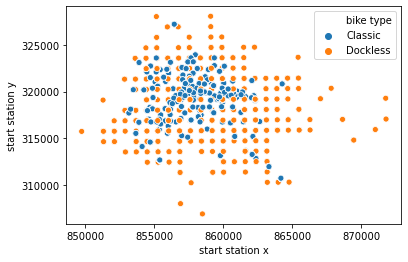

In [67]:
# Scatterplot of station locations and dockless bike 'locations'
sns.scatterplot(x=df['start station x'],y=df['start station y'], hue=df['bike type'])

In [40]:
# create Euclidean distance function
def dist_euc(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

# create taxi-cab distance function
def dist_taxi(x1,y1,x2,y2):
    return np.abs(x1-x2) + np.abs(y1-y2)

# Create distance between stations column
#df['station_distance']=np.zeros(len(df))
for j in df.index:
    df.loc[j,'station_distance'] = dist_taxi(df.loc[j,'start station x'], df.loc[j,'start station y'], df.loc[j,'end station x'], df.loc[j,'end station y'])

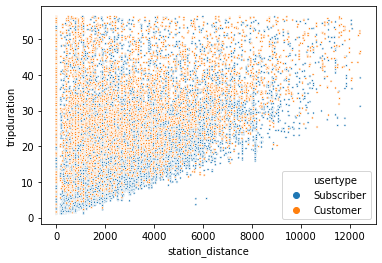

In [66]:
sns.scatterplot(x='station_distance', y='tripduration', hue='usertype', 
                data=df[ df['station_distance']<12500], s=5)

# Take out NRM Bike Shop 1 instances
This appears to be a repair shop, not an actual destination.

In [43]:
print(df.shape)
df = df[df['start station name']!='NRM Bike Shop 1']
print(df.shape)

(66326, 25)
(66324, 25)


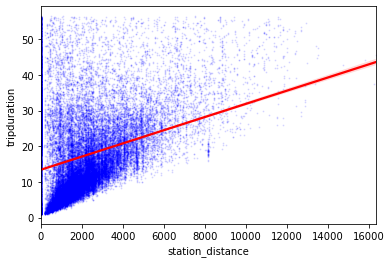

In [91]:
sns.regplot(x='station_distance', y='tripduration', data=df[df['bike type'] == 'Classic'],
            color = 'blue', scatter_kws={'s':1, 'alpha':0.1}, line_kws={'color':'red'})

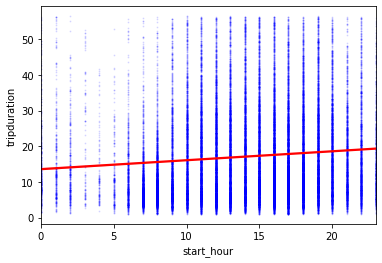

In [95]:
sns.regplot(x='start_hour', y='tripduration', data=df[df['bike type'] == 'Classic'],
            color = 'blue', scatter_kws={'s':1, 'alpha':0.1}, line_kws={'color':'red'})

Clearly, and intuitively, regression is not going to be a fantastic 

In [96]:
corr_matrix = df.corr()

In [97]:
corr_matrix['tripduration'].sort_values(ascending=False)

tripduration               1.000000
station_distance           0.354221
startdayofweek             0.150354
enddayofweek               0.150168
end station id             0.100538
start_hour                 0.093162
start station id           0.084403
bikeid                    -0.071162
birth year                -0.110199
end station x             -0.117408
end station longitude     -0.119412
start station x           -0.120888
start station longitude   -0.122701
gender                    -0.169343
start station latitude    -0.218896
start station y           -0.219750
end station latitude      -0.235186
end station y             -0.236000
long_trip                       NaN
Name: tripduration, dtype: float64

In [ ]:
from pandas.plotting import scatter_matrix

atts = ['tripduration', 'wind_speed', 'dew_point',
       'temperature', 'precipitation', 'station_distance']
scatter_matrix(df[atts], figsize=(15,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a13e7f0>,
      dtype=object)

# Problem statement
We want to see if we can predict if a customer will ride a bike longer than 30 minutes. After 30 minutes, additional charges apply. We created a `long_trip` feature for trips longer than 30 minutes (True).

**Note** This problem statement has undergone modification. What follows may not address this precise problem.

## Feature selection.
We have a small issue that `Dockless` bikes do not have start/end stations. For the moment, I am going to restrict my attention to the `Classic` `bike type`.

The features I will use are `start_hour`, `start station latitude`, `start station longitude`, `end station latitude`, `end station longitude`, `usertype`, `birth year`, `gender`, `startdayofweek`. The response variable will be `long_trip`.

# Alternate problem statement
After removing long (2 hours) trips, can we use regression to predict tripduration?

In [68]:
X = df[['start_hour', 'start station latitude', 'start station longitude', 'end station latitude',
        'end station longitude', 'usertype', 'gender', 'startdayofweek', 'bike type', 'station_distance']]

# Trip dataframe to remove dockless bikes
X = X[X['bike type'] == 'Classic']

# Remove 'bike type' column
X.drop(columns='bike type', inplace=True)

X.sample(3)

,start_hour,start station latitude,start station longitude,end station latitude,end station longitude,usertype,gender,startdayofweek,station_distance
56539,14,44.980500,-93.261800,44.973378,-93.234762,Subscriber,1,5,2911.608487
55422,1,44.972404,-93.242891,44.968760,-93.210030,Customer,0,5,2976.308085
70612,11,44.948703,-93.306212,44.948703,-93.306212,Customer,0,5,0.000000


In [69]:
# y is a continuous variable, so it's a regression problem
y = df[df['bike type'] == 'Classic'].tripduration

In [70]:
print(X.shape)
print(y.shape)

(46418, 9)
(46418,)


## Split the data

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

## Build the model
Here we will look at LinearRegression

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Find categorical columns
categorical_cols = [cname for cname in X.columns if
                   X[cname].dtype == 'object']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Bundle preprocessing for pipeline
preprocessor = ColumnTransformer(transformers =[
#    ('num', numerical_transformer, numerical_cols), # numerical columns not missing data. May use when trying dockless
    ('cat', categorical_transformer, categorical_cols)
])

# Use Linear Regression
model = LinearRegression()

# Use Logistic Regression
#model = LogisticRegression(max_iter=5000, solver='lbfgs', C=0.05)

# Use KNN
#model = KNeighborsClassifier(n_neighbors=10)

# Construct pipeline
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', model)
])


In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
cv_scores = -1*cross_val_score(my_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')

print("scores are", cv_scores)
print("average score is", cv_scores.mean())

scores are [9.16104389 8.70917416 9.13622425 8.84814505 8.81174578]
average score is 8.933266623073687


## Random Forest Regressor
Implement Random Forest Regressor here

In [79]:
from sklearn.ensemble import RandomForestClassifier

# Find categorical columns
categorical_cols = [cname for cname in X.columns if
                   X[cname].dtype == 'object']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Bundle preprocessing for pipeline
preprocessor = ColumnTransformer(transformers =[
#    ('num', numerical_transformer, numerical_cols), # numerical columns not missing data. May use when trying dockless
    ('cat', categorical_transformer, categorical_cols)
])

# Use Linear Regression
model = RandomForestClassifier()

# Use Logistic Regression
#model = LogisticRegression(max_iter=5000, solver='lbfgs', C=0.05)

# Use KNN
#model = KNeighborsClassifier(n_neighbors=10)

# Construct pipeline
my_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('model', model)
])



In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
cv_scores = -1*cross_val_score(my_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')

print("scores are", cv_scores)
print("average score is", cv_scores.mean())

scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 330, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 558, in _validate_y_class_weight
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classifica

## K Nearest Neighbors
KNN is used for a categorical response variable.
Here we try the KNN model. We will look at several different N values

In [76]:

# Find categorical columns
categorical_cols = [cname for cname in X.columns if
                   X[cname].dtype == 'object']

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

# Bundle preprocessing for pipeline
preprocessor = ColumnTransformer(transformers =[
#    ('num', numerical_transformer, numerical_cols), # numerical columns not missing data. May use when trying dockless
    ('cat', categorical_transformer, categorical_cols)
])

# Use Logistic Regression
#model = LogisticRegression(max_iter=5000, solver='lbfgs', C=0.05)

# Use KNN
# Loop through 2 to 20 neighbors
n_scores=[]
for n in range(2,20):
    model = KNeighborsClassifier(n_neighbors=n)
    # Construct pipeline
    my_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('model', model)])
    
    cv_scores = -1*cross_val_score(my_pipe, X, y, cv=5, scoring='neg_mean_absolute_error')
    
    print("for ",n, "neighbors, scores are", cv_scores)
    print("average score is", cv_scores.mean())
    n_scores.append(cv_scores.mean())
n_scores.plot()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  2 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  3 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  4 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  5 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  6 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  7 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  8 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  9 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  10 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  11 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  12 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  13 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  14 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  15 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  16 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  17 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

for  18 neighbors, scores are [nan nan nan nan nan]
average score is nan
for  19 neighbors, scores are [nan nan nan nan nan]
average score is nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_base.py", line 1146, in fit
    check_classification_targets(y)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/multiclass.py", line 172, in check_classification_targets
    raise ValueError("Unknown label type: %r" % y_type)
ValueError: Unknown label type: 'continuous'

  warnings.warn("Estimator fit failed. The score on this train-test"

AttributeError: 'list' object has no attribute 'plot'